In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

### Discriminant Analysis

I use the MLE to fit gaussians

In [2]:
num_c1 = 200
#params are [mu,sigma^2]
c1_params = [3,1.5]
num_c2 = 200
c2_params = [0,1.5]
x1 = (np.random.normal(size=(num_c1,2)) *  c1_params[1] +  c1_params[0])
x2 = (np.random.normal(size=(num_c2,2)) * c2_params[1] + c2_params[0])
x = np.concatenate((x1,x2))
y = np.zeros((num_c1+num_c2))
y[num_c1:num_c1+num_c2] = 1

shuffle_inds = np.random.permutation(x.shape[0])
x = x[shuffle_inds]
y = y[shuffle_inds]

ind = int(x.shape[0]/2)
x_train = x[:ind]
y_train = y[:ind]
x_test = x[ind:]
y_test = y[ind:]

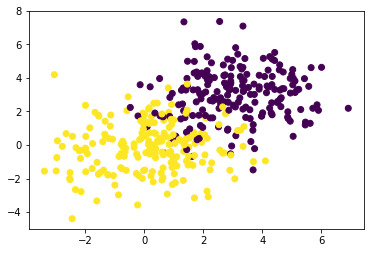

In [3]:
plt.scatter(x[:,0],x[:,1],c=y)

In [4]:
#We want to fit a MVN to the data.  
#To do this, we can use the MLE estimate for our parameters mu_c (vector), and sigma_c (matrix)
#The MLE estimate is the empirical mean and empirical covariance.
#np.cov takes in a matrix where rows are variables and columns are data
#result should be a 2x2 (or num_axisXnum_axis) matrix

def GDA(x,y):
    mu_l = []
    voc_l = []

    for cls in np.unique(y):
        x_c = x[y==cls]
        mu = np.mean(x_c,axis=0)
        voc = np.cov(x_c.transpose())
        mu_l.append(mu)
        voc_l.append(voc)

    mu_l = np.array(mu_l)
    voc_l = np.array(voc_l)
    
    rvs = []
    
    for i in range(len(mu_l)):
        rvs.append(multivariate_normal(mu_l[i], voc_l[i],allow_singular=True))

    return rvs

def LDA(x,y):
    mu_l = []
    voc_l = []

    for cls in np.unique(y):
        x_c = x[y==cls]
        mu = np.mean(x_c,axis=0)
        mu_l.append(mu)

    mu_l = np.array(mu_l)
    voc_l = np.array([np.cov(x.transpose())])
    
    rvs = []
    
    for i in range(len(mu_l)):
        rvs.append(multivariate_normal(mu_l[i], voc_l[0],allow_singular=True))
        
    return rvs

def DiagLDA(x,y):
    mu_l = []
    voc_l = []

    for cls in np.unique(y):
        x_c = x[y==cls]
        mu = np.mean(x_c,axis=0)
        mu_l.append(mu)

    mu_l = np.array(mu_l)
    voc_l = np.array([np.diag(np.var(x,axis=0))])
    
    rvs = []
    
    for i in range(len(mu_l)):
        rvs.append(multivariate_normal(mu_l[i], voc_l[0],allow_singular=True))
        
    return rvs

def plot_contours_with_data(x,y,rvs, t = 'GDA'):
    X, Y = np.meshgrid(np.linspace(-6,10,500),np.linspace(-6,10,500))
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X; pos[:, :, 1] = Y
            
    #Make a 3D plot
    plt.figure()
    plt.title(t)
    plt.scatter(x[:,0],x[:,1],c=y)

    for i in range(len(rvs)):
        plt.contour(X,Y,rvs[i].pdf(pos))

    plt.show()


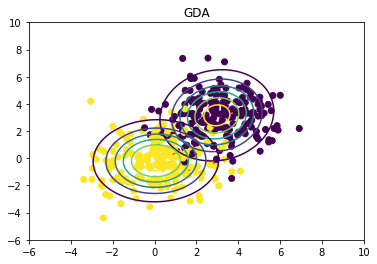

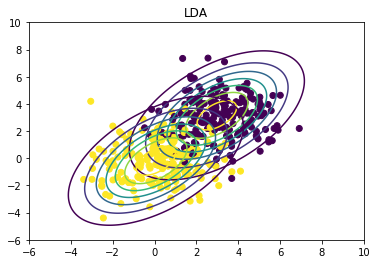

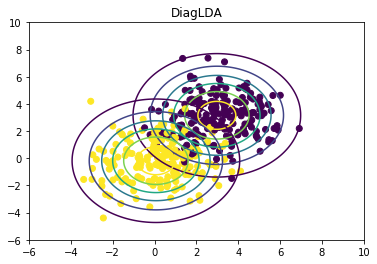

In [5]:
rvs_gda = GDA(x_train,y_train)
plot_contours_with_data(x,y,rvs_gda)

rvs_lda = LDA(x_train,y_train)
plot_contours_with_data(x,y,rvs_lda,t='LDA')

rvs_dlda = DiagLDA(x_train,y_train)
plot_contours_with_data(x,y,rvs_dlda,t='DiagLDA')

In [6]:
#Now perform classifications.
#GDA (and QDA) uses prediction(x) = argmax_c [log p(y=c|pi) + log p(x|theta_c)], 
#   where log p(x|theta_c) is equivalent to the distance from x to the center mu_c 
#LDA uses the same computation

#pi is a list of class priors (N_c/N)
def predict(x_test, pi, rvs):
    preds = np.hstack(( pi[0] * rvs[0].pdf(x_test).reshape((-1,1)), pi[1] * rvs[1].pdf(x_test).reshape((-1,1))) ) 
    preds = np.argmax(preds,axis=1)
    #print(preds)
    #print(preds == y_test)
    return preds

In [7]:
pi = [sum(y) / len(y), (len(y) - sum(y)) / len(y)]
preds = predict(x_test,pi,rvs_dlda)
acc = sum(preds == y_test) / len(y_test)
print("Accuracy: %f" %acc)

Accuracy: 0.915000


In [ ]:
import sklearn
from sklearn import *

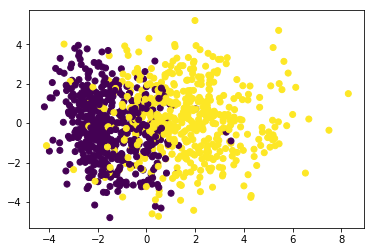

In [9]:
x,y = sklearn.datasets.make_classification(n_samples=1000,n_features = 500)


#This data is pretty crazy!  We need to scale it in order to avoid ill-conditioned convariance matrices
#x = (x - np.mean(x,axis=0)) / np.std(x,axis=0)

pca = sklearn.decomposition.PCA(n_components=2)
vx = pca.fit_transform(x)
plt.scatter(vx[:,0],vx[:,1],c=y)

shuffle_inds = np.random.permutation(x.shape[0])
x = x[shuffle_inds]
y = y[shuffle_inds]

ind = int(x.shape[0]/4)
x_train = x[ind:]
y_train = y[ind:]
x_test = x[:ind]
y_test = y[:ind]

In [10]:
rvs_gda = GDA(x_train,y_train)
rvs_lda = LDA(x_train,y_train)
rvs_dlda = DiagLDA(x_train,y_train)

In [11]:
pi = [sum(y) / len(y), (len(y) - sum(y)) / len(y)]

preds = predict(x_test,pi,rvs_dlda)
print("DLDA Accuracy: %f" % (sum(preds == y_test) / len(y_test)))

preds = predict(x_test,pi,rvs_lda)
print("LDA Accuracy: %f" % (sum(preds == y_test) / len(y_test)))

preds = predict(x_test,pi,rvs_gda)
print("GDA Accuracy: %f" % (sum(preds == y_test) / len(y_test)))

DLDA Accuracy: 0.820000
LDA Accuracy: 0.496000
GDA Accuracy: 0.516000


In [12]:
#We see that DLDA performs pretty well on high dimensional data; this is because constraining
#  the covariance matrix to a diagonal gives us significant regularization.
#  For example, with 500 features, the covariance matrix of GDA/LDA will be 500x500, ill conditioned
#  and may be very sparse.
#Additionally, I have to set allow_singular to true in order for GDA or LDA to even work